In [4]:
from datetime import datetime
import pickle

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error
)
from xgboost import XGBRegressor

from scripts.data_processing import (
    load_uci, load_tidepool_dummy, 
    load_so_pump, 
    load_so_cgm
)

In [112]:
def resample(df, freq='5Min', value_col='value'):
    """Converts measurements to a given interval"""
    df = df.copy()
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    
    desired_dts = pd.date_range(df['timestamp'].min().round(freq),
                                df['timestamp'].max().round(freq), 
                                freq=freq)
    
    interp = np.interp(desired_dts, df['timestamp'], df[value_col])
    
    df = pd.DataFrame({'timestamp':desired_dts,
                       'value':interp})
    
    return df


def feature_engineer(df):
    df = df.copy()
    df = pd.concat(
        [df, 
         pd.get_dummies(df['timestamp'].dt.hour, prefix='hour_of_day'),
         pd.get_dummies(df['timestamp'].dt.weekday, prefix='day_of_week')], 
        axis=1
    )
    
    return df


def type_check(df):
    for col in ['timestamp', 'value', 'below_threshold']:
        assert pd.api.types.is_numeric_dtype(df[col])
    
    return None


def append_historical_bg_cols(df, n_value_cols=12, n_rate_cols=0, interval_mins=5):
    """Adds recent blood glucose measures as columns"""
    df = df.copy()
    
    for x in range(1, max([n_value_cols, n_rate_cols])+1):
        df[['prev_val', 'prev_time']] = df[['value', 'timestamp']].shift(x)
        if x <= n_value_cols:
            df[f'value_lag{str(x).zfill(2)}'] = df['value'].shift(x)
        if x <= n_rate_cols:
            df[f'value_per_min_lag{str(x).zfill(2)}'] = (
                (df['value'].shift(x-1) - df['value'].shift(x)).divide(interval_mins)
            )
        df = df.drop(columns=['prev_val', 'prev_time'])

    return df


def append_future_target_col(df, minutes=30):
    """Append target column for machine learning model"""
    df = df.copy()

    target_name = f'future_value_{str(minutes).zfill(2)}_minutes'
    df[target_name] = df['value'].shift(int(-minutes/5))
    
    return df


def split_train_validate(df, minutes=30, test_fraction=0.2):
    df = df.copy()
    
    test_size = int(df.shape[0] * test_fraction)
    df_train = df.iloc[0:-test_size]
    df_val   = df.iloc[-test_size:]
    print(f'train size: {len(df_train)}')
    print(f'test size: {len(df_val)}')
    
    target_name = f'future_value_{str(minutes).zfill(2)}_minutes'
    X_train  = df_train.drop(columns=[target_name])
    y_train  = df_train[target_name]
    
    X_val    = df_val.drop(columns=[target_name])
    y_val    = df_val[target_name]
    
    return X_train, X_val, y_train, y_val


def build_model(df, minutes=30):
    df = append_historical_bg_cols(df.copy(), minutes)
    df = append_future_target_col(df.copy(), minutes)
    
    X_train, X_val, y_train, y_val = \
        split_train_validate(df.copy(), minutes=minutes)
    
    param_grid = {  
        'learning_rate': [0.05, 0.06, 0.07, 0.08],
        'n_estimators':  [40, 50, 60],
        'max_depth': [2],
    }

    gridsearch = GridSearchCV(XGBRegressor(),
                              param_grid=param_grid, 
                              # scoring='roc_auc', 
                              cv=3, n_jobs=-1,
                              return_train_score=True, verbose=10)
    gridsearch.fit(X_train, y_train)
    print('best estimator:', gridsearch.best_estimator_)
    print(gridsearch.cv_results_['mean_train_score'].mean(),
          gridsearch.cv_results_['mean_test_score'].mean())
    y_pred = gridsearch.predict(X_val)
    print('mae:', mean_absolute_error(y_val, y_pred))
    print('rmse:', np.sqrt(mean_squared_error(y_val, y_pred)))
    
    return gridsearch


def baseline_rmse(df, minutes=30):
    """Baseline RMSE assuming the target value will be the same
    as the current value
    """
    df = load_so_cgm()
    df = append_future_target_col(df.copy(), minutes)
    df = df.dropna()
    target_name = f'future_value_{str(minutes).zfill(2)}_minutes'
    mse = sum((df[target_name] - 
               df['value']).pow(2)) / len(df)
    
    return np.sqrt(mse)

### Baseline RMSE

In [172]:
for minute in range(5, 31, 5):
    print(str(minute).zfill(2), 'minutes in future:',
          baseline_rmse(df=load_so_cgm(), minutes=minute))

05 minutes in future: 6.719252100307445
10 minutes in future: 10.41333712177528
15 minutes in future: 14.53977672402164
20 minutes in future: 18.158543769341655
25 minutes in future: 21.638654622552746
30 minutes in future: 24.896238216187268


## Model Selection

In [134]:
df = load_so_cgm()
df = resample(df, freq='5Min')
df = feature_engineer(df)
df = append_historical_bg_cols(df, n_rate_cols=0)
df = append_future_target_col(df)
df = df.dropna()
df['timestamp'] = df['timestamp'].astype(np.int64) // 10**9

In [90]:
X_train, X_val, y_train, y_val = (
    split_train_validate(df)
)

train size: 81174
test size: 20293


In [94]:
model = RandomForestRegressor(
    n_estimators=100, 
    min_samples_leaf=0.005, 
    oob_score=True, 
    n_jobs=-1
)

In [95]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=0.005, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [114]:
# train score
mse = mean_squared_error(y_train, model.predict(X_train))
rmse = np.sqrt(mse)
print(rmse)

18.05144289858706


In [115]:
# test score
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print(rmse)

21.969818719388282


In [121]:
pd.Series(model.feature_importances_, 
          X_train.columns).sort_values(ascending=False)

value             0.945597
value_lag04       0.015383
value_lag03       0.012049
value_lag05       0.011840
value_lag02       0.005378
value_lag06       0.004616
value_lag07       0.003653
value_lag08       0.000451
value_lag01       0.000298
value_lag12       0.000219
value_lag09       0.000180
value_lag11       0.000159
timestamp         0.000093
value_lag10       0.000086
day_of_week_5     0.000000
day_of_week_4     0.000000
hour_of_day_0     0.000000
hour_of_day_1     0.000000
hour_of_day_2     0.000000
hour_of_day_3     0.000000
hour_of_day_4     0.000000
hour_of_day_5     0.000000
hour_of_day_6     0.000000
hour_of_day_7     0.000000
hour_of_day_8     0.000000
hour_of_day_9     0.000000
hour_of_day_10    0.000000
hour_of_day_11    0.000000
hour_of_day_12    0.000000
hour_of_day_13    0.000000
hour_of_day_14    0.000000
hour_of_day_15    0.000000
hour_of_day_16    0.000000
hour_of_day_17    0.000000
hour_of_day_18    0.000000
hour_of_day_19    0.000000
day_of_week_6     0.000000
h

In [128]:
# feature importances
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, scoring='neg_mean_squared_error', n_iter=1, cv='prefit')
permuter.fit(X_train, y_train)

PermutationImportance(cv='prefit',
           estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=0.005, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False),
           n_iter=1, random_state=None, refit=True,
           scoring='neg_mean_squared_error')

In [129]:
eli5.show_weights(permuter, top=None, feature_names=X_train.columns.tolist())

Weight,Feature
4354.2255 ± 0.0000,value
37.4356 ± 0.0000,value_lag04
33.8106 ± 0.0000,value_lag03
29.4848 ± 0.0000,value_lag05
11.5913 ± 0.0000,value_lag02
6.9553 ± 0.0000,value_lag07
5.4765 ± 0.0000,value_lag06
0.6185 ± 0.0000,value_lag12
0.5678 ± 0.0000,value_lag01
0.3897 ± 0.0000,value_lag11


## Plotting

In [166]:
import matplotlib.pyplot as plt

def plot(df, model, duration_mins=30):
    df = df.copy()
    
    min_time = df.sample(1)['timestamp'].values[0]
    max_time = min_time + (duration_mins * 60)
    
    df = df.loc[(min_time <= df['timestamp']) & 
                (df['timestamp'] <= max_time)]

    # actual
    plt.plot(df['timestamp'], 
             df['value'], 
             color='b', marker='P')

    # prediction
    plt.plot(df['timestamp'] + 30 * 60, 
             model.predict(df), 
             color='g', marker='d')
    
    return plt.show()

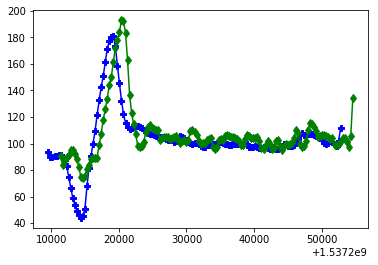

In [170]:
plot(X_train, model, duration_mins=12*60)

## Write Models

In [ ]:
df = load_so_cgm()
models = []
for minutes in range(5, 31, 5):
    with open('diabetesmanager/ml_models/model_' + str(minutes) + '_minutes.pkl', 'wb') as f:
        model = build_model(df.copy(), minutes)
        pickle.dump(model, f)
        models.append(model)

## Read Models

In [ ]:
from pathlib import Path

MODEL_DIR = Path('diabetesmanager/ml_models')
models = []
for model_path in MODEL_DIR.iterdir():
    if str(model_path).endswith('.pkl'):
        with open(model_path, 'rb') as f:
            models.append(pickle.load(f))